Задача определения аномалий.

https://iwringer.wordpress.com/2015/11/17/anomaly-detection-concepts-and-techniques/
https://journalofbigdata.springeropen.com/articles/10.1186/s40537-014-0011-y

### Добавим необходимые библиотеки

In [68]:
import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope

from pyemma import msm

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

C:\Users\DOULASOV\AppData\Local\Continuum\anaconda3\lib\site-packages\pyemma\__init__.py:92: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.7, you have 2.5.6.
  .format(latest=latest, current=current), category=UserWarning)


### Используемые алгритмы:

* Обнаружение аномалий на основе кластерного анализа (K-mean)
* Распределение данных на категории, затем гауссово-эллиптическое разделение.
* Изолирующий лес
* SVM
* RNN (сравнение предсказания и истинных значений )

Определим некоторые вспомогательные функции:

In [85]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

# train markov model to get transition matrix
def getTransitionMatrix (df):
	df = np.array(df)
	model = msm.estimate_markov_model(df, 1)
	return model.transition_matrix

def anomalyElement(sequence, threshold, transitionmatrix): 
    if (sucessScore(sequence, transitionmatrix) > threshold):
        return 0
    else:
        return 1

def sucessScore(sequence, transitionmatrix): 
    proba = 0 
    for i in range(1,len(sequence)): 
        if(i == 1): 
            proba = successProbabilityMetric(sequence[i-1], sequence[i], transitionmatrix)
        else:
            proba = proba*successProbabilityMetric(sequence[i-1], sequence[i], transitionmatrix)
    return proba  

def successProbabilityMetric(state1, state2, transitionmatrix): 
    proba = 0 
    for k in range(0,len(transitionmatrix)):
        if (k != (state2-1)):
            proba += transitionmatrix[state1-1][k]
    return 1-proba

def markovAnomaly(df, windows_size, threshold):
    transitionmatrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transitionmatrix))
    return df_anomaly

## 1.1 Загрузка и обработка данных: 


In [14]:
df = pd.read_csv("ambient_temperature_system_failure.csv")

In [15]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
timestamp    7267 non-null object
value        7267 non-null float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB
None


In [16]:
df.head(10)

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551
5,2013-07-04 05:00:00,70.060966
6,2013-07-04 06:00:00,69.279765
7,2013-07-04 07:00:00,69.369608
8,2013-07-04 08:00:00,69.166714
9,2013-07-04 09:00:00,68.986083


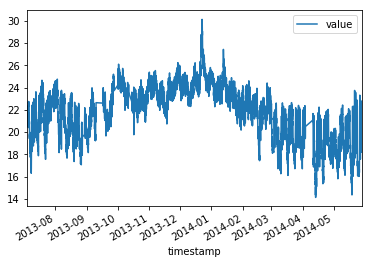

In [17]:
# изменение типа "timestamp" для отрисовки графика
df['timestamp'] = pd.to_datetime(df['timestamp'])
# преобразование °F  в °C 
df['value'] = (df['value'] - 32) * 5/9
df.plot(x='timestamp', y='value')

### 1.2 Обработка и создание новых признаков

In [18]:
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

In [19]:
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)

outliers_fraction = 0.01

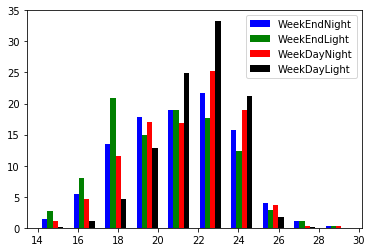

In [20]:
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

# создание  4 уникальных категорий
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

Видно, что температура более стабильна в дневное время рабочего дня.

## 2. Модели

### 2.1 Кластеризация 

Будем использовать для объединения аномалий (неупорядоченных)

Будем группировать точки с типовой комбинацией признков. Точки, лежащие далеко от кластеров являются точками с нетипичной комбинацией признаков. Будем считать их аномалиями.

In [21]:
# Выберем полезные признаки и проведем нормировку
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# Воспользуемся методом главных компонент и сократим количество признаков до 2
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# проведем их нормировку
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)


C:\Users\DOULASOV\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\DOULASOV\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


С помощью метода "локтя" (elbow method) рассчитаем изменения в результатах в зависимости от каличества групп K

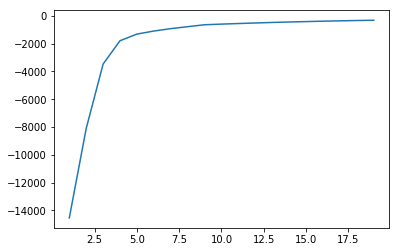

In [22]:

n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [23]:
# Выберем число групп 15
df['cluster'] = kmeans[14].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

0     596
10    590
5     590
2     582
6     555
1     554
12    524
13    520
11    517
4     461
14    432
7     350
3     350
8     338
9     308
Name: cluster, dtype: int64

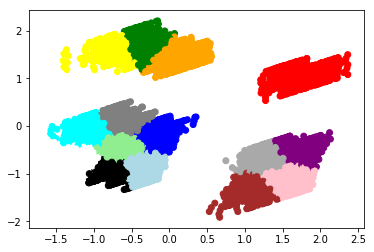

In [24]:
#отрисуем различные кластеры для 2 главных признаков
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

Теперь посчитаем расстояние от каждой точки то ближайшего кластера. Самые большие расстояния будут считаться аномалией.

In [25]:
distance = getDistanceByPoint(data, kmeans[14])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
df['anomaly21'] = (distance >= threshold).astype(int)

C:\Users\DOULASOV\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


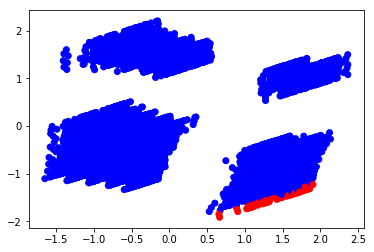

In [26]:
# отобразим анамалии в кластерном виде
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: colors[x]))
plt.show()

Визуализация аномалий во времени.

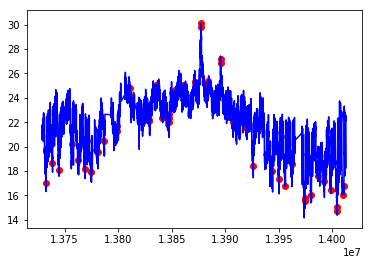

In [27]:

fig, ax = plt.subplots()

a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

Визуализация аномалий в виде распределения температуры

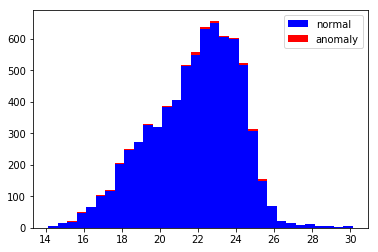

In [28]:
a = df.loc[df['anomaly21'] == 0, 'value']
b = df.loc[df['anomaly21'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

Кластерный метод определяет низкую температуру как необычно низкую, но не определяет самую высокую температуру.

### 2.2 Разделение на категории + гауссово разделение

Для начала разделим данные на 4 категории, которые были определены ранее.

In [29]:
df_class0 = df.loc[df['categories'] == 0, 'value']
df_class1 = df.loc[df['categories'] == 1, 'value']
df_class2 = df.loc[df['categories'] == 2, 'value']
df_class3 = df.loc[df['categories'] == 3, 'value']

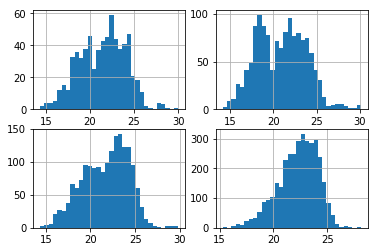

In [30]:
# распределение температуры по категориям
fig, axs = plt.subplots(2,2)
df_class0.hist(ax=axs[0,0],bins=32)
df_class1.hist(ax=axs[0,1],bins=32)
df_class2.hist(ax=axs[1,0],bins=32)
df_class3.hist(ax=axs[1,1],bins=32)

Применим ellipticEnvelope (Гауссово распределение) к каждой категории.

In [31]:
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class2.values.reshape(-1,1)
envelope.fit(X_train)
df_class2 = pd.DataFrame(df_class2)
df_class2['deviation'] = envelope.decision_function(X_train)
df_class2['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class3.values.reshape(-1,1)
envelope.fit(X_train)
df_class3 = pd.DataFrame(df_class3)
df_class3['deviation'] = envelope.decision_function(X_train)
df_class3['anomaly'] = envelope.predict(X_train)

Распределение температур с аномалиями.

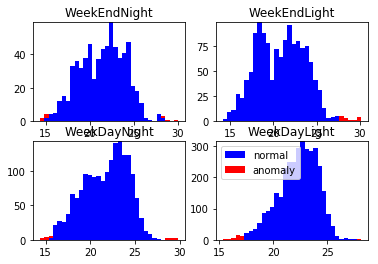

In [32]:
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'value']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'value']

a1 = df_class1.loc[df_class1['anomaly'] == 1, 'value']
b1 = df_class1.loc[df_class1['anomaly'] == -1, 'value']

a2 = df_class2.loc[df_class2['anomaly'] == 1, 'value']
b2 = df_class2.loc[df_class2['anomaly'] == -1, 'value']

a3 = df_class3.loc[df_class3['anomaly'] == 1, 'value']
b3 = df_class3.loc[df_class3['anomaly'] == -1, 'value']

fig, axs = plt.subplots(2,2)
axs[0,0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,1].hist([a1,b1], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,0].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,1].hist([a3,b3], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,0].set_title("WeekEndNight")
axs[0,1].set_title("WeekEndLight")
axs[1,0].set_title("WeekDayNight")
axs[1,1].set_title("WeekDayLight")
plt.legend()
plt.show()

In [33]:
df_class = pd.concat([df_class0, df_class1, df_class2, df_class3])
df['anomaly22'] = df_class['anomaly']
df['anomaly22'] = np.array(df['anomaly22'] == -1).astype(int) 

Аномалии во времени

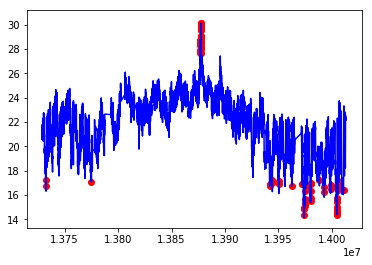

In [34]:
fig, ax = plt.subplots()

a = df.loc[df['anomaly22'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

Аномалии в распределении температуры

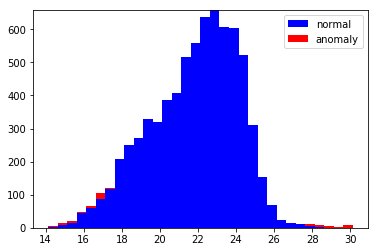

In [35]:
a = df.loc[df['anomaly22'] == 0, 'value']
b = df.loc[df['anomaly22'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

Видим, что разделение на котегории повысило точность обнаружения аномалий.

### Цепи Маркова

Используются для последовательностей аномалий.
Необходимо дискретизировать данные в определенных состояниях для цепей Маркова. Разделим  значение на 5 уровней  (очень низкий, низкий, средний, высокий, очень высокий). Цепь Маркова будет вычислять вероятность последовательности типа (ОН, Н, Н, С, С, В, ОВ). Если вероятность очень мала, мы рассматриваем последовательность как аномалию.

In [92]:
# дискретизация
x1 = (df['value'] <=18).astype(int)
x2= ((df['value'] > 18) & (df['value']<=21)).astype(int)
x3 = ((df['value'] > 21) & (df['value']<=24)).astype(int)
x4 = ((df['value'] > 24) & (df['value']<=27)).astype(int)
x5 = (df['value'] >27).astype(int)
df_mm = x1 + 2*x2 + 3*x3 + 4*x4 + 5*x5


# используем PyEMMA
df_anomaly = markovAnomaly(df_mm, 5, 0.20)
df_anomaly = pd.Series(df_anomaly)
print(df_anomaly.value_counts())

0    7147
1     120
dtype: int64


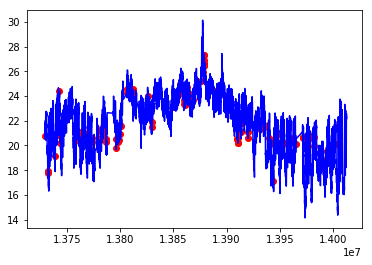

In [89]:

# Добавление данных
df['anomaly24'] = df_anomaly

# визуализация данных
fig, ax = plt.subplots()

a = df.loc[df['anomaly24'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()


No handles with labels found to put in legend.


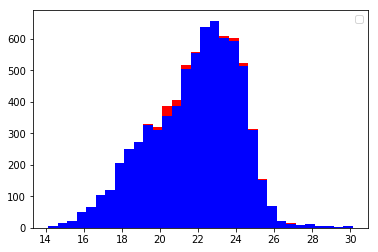

In [93]:

# аномаии в температурном представлении
a = df.loc[df['anomaly24'] == 0, 'value']
b = df.loc[df['anomaly24'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()


### 2.4 Изолирующий лес

Хорошо работает с разнораспределенными данными и эффективен при больших размерностях данных. 

In [86]:
# выберем полезные признаки и проведем стандартизацию
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df['anomaly25'] = pd.Series(model.predict(data))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

C:\Users\DOULASOV\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\DOULASOV\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\DOULASOV\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


0    7194
1      73
Name: anomaly25, dtype: int64


C:\Users\DOULASOV\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


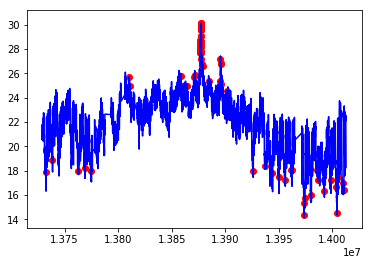

In [37]:
# Аномалии во времени
fig, ax = plt.subplots()

a = df.loc[df['anomaly25'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

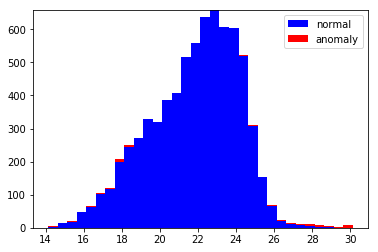

In [38]:
# аномалии в распределении температуры
a = df.loc[df['anomaly25'] == 0, 'value']
b = df.loc[df['anomaly25'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

### 2.5 Одноклассовый SVM

Хороший метод для обнаружения новизны. Предпочтителен для мультимодальных данных.

In [39]:
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df['anomaly26'] = pd.Series(model.predict(data))
df['anomaly26'] = df['anomaly26'].map( {1: 0, -1: 1} )
print(df['anomaly26'].value_counts())

0    7198
1      69
Name: anomaly26, dtype: int64


C:\Users\DOULASOV\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\DOULASOV\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


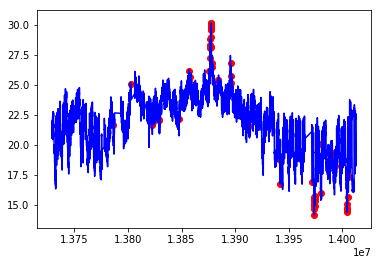

In [40]:

fig, ax = plt.subplots()

a = df.loc[df['anomaly26'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

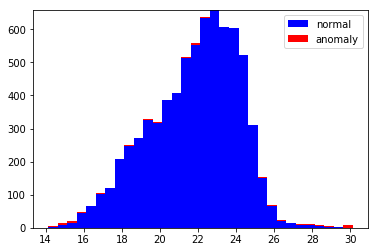

In [41]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly26'] == 0, 'value']
b = df.loc[df['anomaly26'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

Получен результат, аналогичный изолированному лесу, но также найдены аномалии в средних значениях.

### 2.6 RNN

RNN позволяет распознавать последовательности в данных и затем делать прогноз на основе предыдущей последовательности.
Исходя из предыдущих 50 значений сделаем предсказание для следующей виличины.

In [42]:
#выбор и стандартизация данных
data_n = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

# параметры и размер выборок
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#train data
x_train = data_n[0:-prediction_time-testdatacut].as_matrix()
y_train = data_n[prediction_time:-testdatacut  ][0].as_matrix()

# test data
x_test = data_n[0-testdatacut:-prediction_time].as_matrix()
y_test = data_n[prediction_time-testdatacut:  ][0].as_matrix()

C:\Users\DOULASOV\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\DOULASOV\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\DOULASOV\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\DOULASOV\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
C:\Users\DOULASOV\AppData\Local\Continuum\anaconda3\lib\site-packages\ipyk

In [43]:
#для кождого элемента создадим последовательность из 50 элементов
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)


x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]


print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (6165, 50, 5)
y_train (6165,)
x_test (1000, 50, 5)
y_test (1000,)


In [46]:
# Библиотеки для RNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time #helper libraries
from keras.models import model_from_json
import sys

In [48]:
# Построение модели
model = Sequential()

model.add(LSTM(
    input_dim=x_train.shape[-1],
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

C:\Users\DOULASOV\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
C:\Users\DOULASOV\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 5), units=50)`
  import sys


compilation time : 0.019947528839111328


In [49]:
# Train the model
#nb_epoch = 350

model.fit(
    x_train,
    y_train,
    batch_size=3028,
    nb_epoch=30,
    validation_split=0.1)

Instructions for updating:
Use tf.cast instead.


C:\Users\DOULASOV\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 5548 samples, validate on 617 samples
Epoch 1/30
5548/5548 [==============================] - 4s 756us/step - loss: 0.5165 - val_loss: 0.5437
Epoch 2/30
5548/5548 [==============================] - 4s 655us/step - loss: 0.1986 - val_loss: 0.3348
Epoch 3/30
5548/5548 [==============================] - 4s 645us/step - loss: 0.1356 - val_loss: 0.3143
Epoch 4/30
5548/5548 [==============================] - 4s 664us/step - loss: 0.1193 - val_loss: 0.2497
Epoch 5/30
5548/5548 [==============================] - 3s 628us/step - loss: 0.1017 - val_loss: 0.2250
Epoch 6/30
5548/5548 [==============================] - 4s 664us/step - loss: 0.0983 - val_loss: 0.1918
Epoch 7/30
5548/5548 [==============================] - 4s 703us/step - loss: 0.1273 - val_loss: 0.1811
Epoch 8/30
5548/5548 [==============================] - 4s 689us/step - loss: 0.0927 - val_loss: 0.1765
Epoch 9/30
5548/5548 [==============================] - 4s 715us/step - loss: 0.0859 - val_loss: 0.1646
Epoch 10/30
5548/

In [54]:
# сохраним модель 
"""
# serialize model to JSON
model_json = model.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model2.h5")
print("Saved model to disk")
"""

Saved model to disk


In [56]:
# загрузка json и создание модели
"""
json_file = open('model2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model2.h5")
print("Loaded model from disk")
"""

Loaded model from disk


In [57]:
# создание списка различий предсказанных и тестовых данных
loaded_model = model
diff=[]
ratio=[]
p = loaded_model.predict(x_test)
# predictions = lstm.predict_sequences_multiple(loaded_model, x_test, 50, 50)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

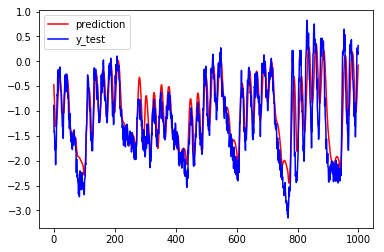

In [59]:
# отрисовка предсказанных значений
fig, axs = plt.subplots()
axs.plot(p,color='red', label='prediction')
axs.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

In [60]:
# в качестве аномалий выберем самые удаленные точки
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
# тестовые данные с аномалиями
test = (diff >= threshold).astype(int)
# данные для обучения без предсказаний
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
# добавление данных
df['anomaly27'] = complement.append(test, ignore_index='True')
print(df['anomaly27'].value_counts())

0    7257
1      10
Name: anomaly27, dtype: int64


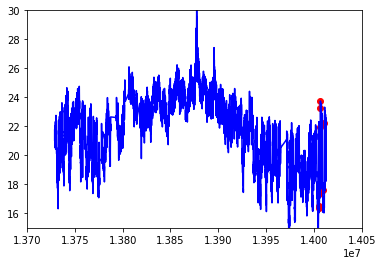

In [61]:
# визуализация данных во времени
fig, ax = plt.subplots()

a = df.loc[df['anomaly27'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.axis([1.370*1e7, 1.405*1e7, 15,30])
plt.show()

No handles with labels found to put in legend.


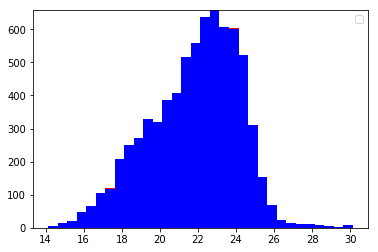

In [62]:
# аномалии в отображении температуры
a = df.loc[df['anomaly27'] == 0, 'value']
b = df.loc[df['anomaly27'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()